Por: Felipe Moreira

Análisis de Sentimientos de Twitter

## Parte 1

### 1. Preliminares

* El problema trata de poder clasificar la polaridad de distintos tweeters de a cuerdo a su sentimiento que representan
* El objetivo consiste en poder identificar con la mayor exactitud posible si un tweet tiene una polaridad negativa o positiva.
* La base entregada nos entrega una columna con el tweet y otra con el sentimiento que se identifica en cada tweet.
* El problema se trata de un problema de clasificación ya que hay que debemos clasificar los tweets entre dos clases (polaridad negativa o positiva)
* Los atributos que tenemos disponibles son los mismos tweets compuestos por distintas palabras
* El vector objetivo actual indica el sentimiento del tweet, debe ser recodificado para indicar si es positivo o negativo

**La metodología a seguir será la siguiente:**

1. Preprocesar la info: eliminar palabras irrelevantes (stopwords), pasarán a lowercase, se probará con lemantización y steamming también para evaluar mejores resultados. También se transformará el vector objetivo a sentimiento positivo y negativo de acuerdo a lo indicado.
2. Extraer características: pasar a matriz numérica (Bag of words) para poder entregarles los datos al modelo y que los entienda de mejor manera
3. Dividir el conjunto de datos: entre entrenamiento y prueba para entrenar y probar los modelos mediante train_test_split
4. seleecionar los algoritmos de clasificación a utilizar y sus grillas con valores de hiperparámetros a probar: 
    * Naive bayes
    * Support Vector Machine (SVM): {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10,1000]}
    * Arboles de descición: {'max_features': list(range(1, X_train.shape[1])),
                                 'max_depth': np.linspace(1, 32, num=32, endpoint=True)}
    * Random Forest: 'n_estimators': n_estimators,  # Número de árboles en el bosque
    'max_depth': [None, 5, 10],  # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en cada hoja del árbol
    * AdaBoost y Gradient Boost
    * Ligth GBM
5. Entrenar y ajustar el modelo
6. Evaluar rendimientos de los modelos: se evaluará el desempeño de metricas como recall, presicion, accuracy y F1. Tambien se evaluará el uso de Confusion matrix y la curva ROC

Librerias a implementar:
* Pandas: para la manipulación y análisis de datos.
* NumPy: para realizar operaciones numéricas y manipulación de matrices.
* Scikit-learn: para implementar modelos de aprendizaje automático y realizar evaluación de métricas.
* Matplotlib y Seaborn: para visualización de datos.
* nltk: procesamiento de lenguaje natural
* string: procesamiento de string
* random: generación de valores aleatorios

### 2. Aspectos Computacionales

In [2]:
#librerias y modulos a implementar:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import random
import pickle



#from keras.models import Sequential
#from keras.layers import Dense

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felipemoreira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/felipemoreira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#lectura del archivo
df = pd.read_csv('training_tweets.csv').drop(columns='Unnamed: 0')
print(df.shape)
df.head()

(30000, 2)


,content,sentiment
0,Happy Mama's day to all mothers,love
1,@LysdelTellez I am lost. Please help me find a...,worry
2,"@BoomKatt yes yes I AM, networking whore to th...",happiness
3,you@snapplynn Wish that would have been your t...,neutral
4,now i am doing the MicroEconomics project iha...,worry


In [4]:
#funiones a implementar:
#funcion para reportar mejores parametros y puntuación:
def best_hyperparams(model):
    print("Mejores parámetros encontrados: ", model.best_params_)
    print("Mejor puntuación: ", model.best_score_)

#imprimir reporte de clasificación
def plot_classification_report(y_true, y_hat):
    """
    plot_classification_report: Genera una visualización de los puntajes reportados con la función `sklearn.metrics.classification_report`.

    Parámetros de ingreso:
        - y_true: Un vector objetivo de validación.
        - y_hat: Un vector objetivo estimado en función a la matriz de atributos de validación y un modelo entrenado.

    Retorno:
        - Un gráfico generado con matplotlib.pyplot

    """
    # process string and store in a list
    report = classification_report(y_true, y_hat).split()
    # keep values
    report = [i for i in report if i not in ['precision', 'recall', 'f1-score', 'support']]
    # transfer to a DataFrame
    report = pd.DataFrame(np.array(report).reshape(len(report) // 5, 5))
    # asign columns labels
    report.columns = ['idx', 'prec', 'rec', 'f1', 'n']
    # preserve class labels
    class_labels = report.iloc[:np.unique(y_true).shape[0]].pop('idx').apply(int)
    # separate values
    class_report = report.iloc[:np.unique(y_true).shape[0], 1:4]
    # convert from str to float
    class_report = class_report.applymap(float)
    # convert to float average report
    average_report = report.iloc[-1, 1: 4].apply(float)

    colors = ['dodgerblue', 'tomato', 'purple', 'orange']

    for i in class_labels:
        plt.plot(class_report['prec'][i], [1], marker='x', color=colors[i])
        plt.plot(class_report['rec'][i], [2], marker='x', color=colors[i])
        plt.plot(class_report['f1'][i], [3], marker='x',color=colors[i], label=f'Class: {i}')

    plt.scatter(average_report, [1, 2, 3], marker='o', color='forestgreen', label='Avg')
    plt.yticks([1.0, 2.0, 3.0], ['Precision', 'Recall', 'f1-Score'])

### 3. Análisis exploratorio

3.1 estudio del vector objetivo

<AxesSubplot:>

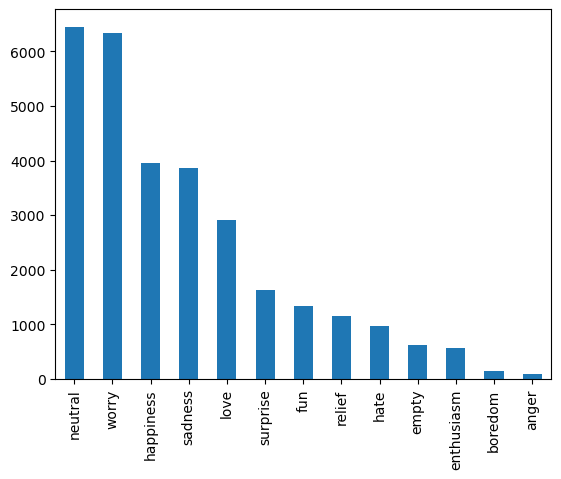

In [5]:
#distribución del vector objetivo
df['sentiment'].value_counts().plot(kind='bar')

In [6]:
df.describe()

,content,sentiment
count,30000,30000
unique,29881,13
top,I just received a mothers day card from my lov...,neutral
freq,12,6451


El vector objetivo esta clarmanete desbalanceado, siendo los sentimientos más comunes: neutral, worry, seguido por happines y saddness. Mas adelante recodificaremos el vector en los dos sentimientos y revisaremos como se comporta.
Los sentimientos observados en menor presencia son boredom y anger

3.2 Estudio de datos nulos

In [7]:
df.isnull().sum()

content      0
sentiment    0
dtype: int64

El archivo utilizado no posee datos nulos, de todas formas hay datos que no nos sirven en los tweets como puntuaciones, menciones(@) y links que serán limpiados posteriormente

Identificación de palabras más comunes en el DF:

In [8]:
#instanciar objeto
count_vectorizer = CountVectorizer(stop_words='english')
#implementar fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(df['content'])
#extraemos los tokens (palabras)
words = count_vectorizer.get_feature_names_out()
#extraer frecuencia
frec_words = count_vectorizer_fit.toarray().sum(axis=0)

#creación de nuevo DF con las palabras y frecuencia de cada una mostrando las 10 de mayor ocurrencia
df_n = pd.DataFrame(np.column_stack((words, frec_words)), columns=['palabras', 'frecuencia'])
df_n = df_n.sort_values('frecuencia', ascending=False)
df_n = df_n.head(10)
df_n

,palabras,frecuencia
9486,day,2403
18732,just,2369
14495,good,1736
20580,like,1444
28178,quot,1399
16306,http,1398
35240,today,1269
21190,love,1245
38245,work,1240
14583,got,1236


En la tabla anterior se muestran las palabras con mayor frecuencia de todos los tweets, previo a la limpieza que realizaremos. Se observan datos que no aportan al modelo como "http"

## Parte 2

### 4. Feature Engineering

4.1 recodificación del vector objetivo

<AxesSubplot:>

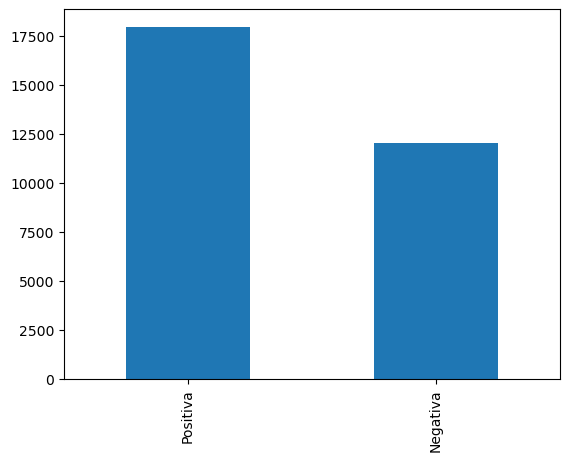

In [9]:
#fijamos semilla para tener el mismo resultado las veces que lo corramos
#random será utilizado para separar al azar los datos "neutral"
random.seed(11238)
np.random.seed(11238)

nuevas_categorias = {'worry': 'Negativa',
                    'happiness': 'Positiva',
                    'sadness': 'Negativa',
                    'love': 'Positiva',
                    'surprise': 'Positiva',
                    'fun': 'Positiva',
                    'relief': 'Positiva',
                    'hate': 'Negativa',
                    'empty': 'Negativa',
                    'enthusiasm': 'Positiva',
                    'boredom': 'Negativa',
                    'anger': 'Negativa',
                    'neutral': random.choice(['Negativa', 'Positiva'])}

df['polaridad'] = df['sentiment'].map(nuevas_categorias)
df['polaridad'].value_counts().plot(kind='bar')

Luego recodificaremos el vector a 0 (positiva) y 1 (negativas) para poder entregarlo a los modelos 

In [10]:
df['polaridad'] = np.where(df['polaridad'] == 'Positiva', 0, 1)
df['polaridad'].value_counts()

0    17978
1    12022
Name: polaridad, dtype: int64

In [11]:
#limpieza de tweets
def limpieza(texto):
    STOPWORDS = stopwords.words('english')
    #revisar si hay puntuaciones
    nopunc = [char for char in texto if char not in string.punctuation]
    nopunc = ''.join(nopunc)

    #remove stopwords
    text =  ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS]).lower()

    #lemmantizer
    lem = WordNetLemmatizer()
    lemmatized_words = [lem.lemmatize(word) for word in text.split()]
    lemmatized_tweet = ' '.join(lemmatized_words)

    #Steeming
    stem = PorterStemmer()
    stemmed_words = [stem.stem(word) for word in lemmatized_tweet.split()]
    stemmed_tweet = ' '.join(stemmed_words)
    return stemmed_tweet


df['clean_tweets'] = df['content'].apply(limpieza)
df.head()

,content,sentiment,polaridad,clean_tweets
0,Happy Mama's day to all mothers,love,0,happi mama day mother
1,@LysdelTellez I am lost. Please help me find a...,worry,1,lysdeltellez lost pleas help find good home
2,"@BoomKatt yes yes I AM, networking whore to th...",happiness,0,boomkatt ye ye network whore fullestand girl r...
3,you@snapplynn Wish that would have been your t...,neutral,0,yousnapplynn wish would tweet follow
4,now i am doing the MicroEconomics project iha...,worry,1,microeconom project ihat subject amp besid eng...


### 5. Modelación

In [12]:
#separación entre conjunto de prueba y testeo
X_train, X_test, y_train, y_test = train_test_split(df['clean_tweets'], df['polaridad'], test_size=.33, random_state=11238)
print('X_train Dimension:', X_train.shape)
print('X_test Dimension:', X_test.shape)
print('Y_train Dimension:', y_train.shape)
print('Y_test Dimension:', y_test.shape)

X_train Dimension: (20100,)
X_test Dimension: (9900,)
Y_train Dimension: (20100,)
Y_test Dimension: (9900,)


In [13]:
#Traspasaremos los tweets a numero mediante el count vectorizer para poder ser entendidos por los modelos
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [14]:
#utilizaremos SMOTE para compensar el desbalanceo de clases
smt = SMOTE()
X_train_vect, y_train = smt.fit_resample(X_train_vect, y_train)
print('X_train Dimension:', X_train_vect.shape)
print('Y_train Dimension:', y_train.shape)

X_train Dimension: (23986, 28334)
Y_train Dimension: (23986,)


Modelos y grillas a implementar

A continuación, se implementarán los siguientes modelos, indicados con sus respectivas grillas:
* Naive bayes
* Support Vector Machine (SVM): {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10,1000]}
* Arboles de descición: {'max_features': list(range(1, X_train.shape[1])),
                                 'max_depth': np.linspace(1, 32, num=32, endpoint=True)}
* Random Forest: 'n_estimators': n_estimators,  # Número de árboles en el bosque
    'max_depth': [None, 5, 10],  # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en cada hoja del árbol
* Adaboost y Gradient Boost: 'learning_rate': [0.01, 0.1, 0.5]
* Redes Neuronales


#### Modelo 1: Naive Bayes

In [161]:
nb = MultinomialNB().fit(X_train_vect, y_train)
yhat = nb.predict(X_test_vect)
confusion_matrix(y_test, yhat)

array([[4224, 1761],
       [1301, 2614]])

In [162]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      5985
           1       0.60      0.67      0.63      3915

    accuracy                           0.69      9900
   macro avg       0.68      0.69      0.68      9900
weighted avg       0.70      0.69      0.69      9900



In [163]:
with open('FML-NB.pkl', 'wb') as file:
    pickle.dump(nb, file)

El modelo con Naive Bayes nos da un accuracy del 71%. Logra predecir con 74% los tweet con polaridad positiva y con 65% los con polaridad negativa. Sin embargo el puntaje f1 es bajo para los negativos por lo que le cuesta identificar los tweets negativos

#### Modelo 2: SVM

In [164]:
#parámetros a implemenar en la grilla
params ={
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10,1000]
}

#creción del modelo y búsqueda de grilla
grid_search_SVM = GridSearchCV(SVC(), params, cv=2, return_train_score=True)
grid_search_SVM.fit(X_train_vect, y_train)

#mejores parámetros
best_hyperparams(grid_search_SVM)

Mejores parámetros encontrados:  {'C': 1000, 'gamma': 0.1}
Mejor puntuación:  0.6376636371216543


In [165]:
#predicción
y_pred = grid_search_SVM.predict(X_test_vect)

#evaluación del modelo
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.68      0.61      0.65      5985
           1       0.49      0.57      0.53      3915

    accuracy                           0.59      9900
   macro avg       0.59      0.59      0.59      9900
weighted avg       0.61      0.59      0.60      9900



In [166]:
with open('FMLL-SVM.pkl', 'wb') as file:
    pickle.dump(grid_search_SVM, file)

El modelo con SVM tiene un acurracy de 72% lo cual es un poco mejor que NB, sin embargo el f1 sigue siendo bajo para las identificaciones negativas por lo que no las logra predecir correctamente

#### Modelo 3: Arboles de desición

In [167]:
#parametros del modelo
params = {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}

#creación del modelo
tree = DecisionTreeClassifier()

#grid search
grid_search_t = GridSearchCV(tree, params, cv=5)
grid_search_t.fit(X_train_vect, y_train)

#mejores parametros
best_hyperparams(grid_search_t)

#predicciones con los mejores parametros
best_clf = grid_search_t.best_estimator_
y_pred = best_clf.predict(X_test_vect)

#evaluación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

Mejores parámetros encontrados:  {'max_depth': None, 'min_samples_split': 10}
Mejor puntuación:  0.6635142343984443
Informe de clasificación:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66      5985
           1       0.50      0.58      0.54      3915

    accuracy                           0.61      9900
   macro avg       0.60      0.60      0.60      9900
weighted avg       0.62      0.61      0.61      9900



In [168]:
with open('FMLL-AD.pkl', 'wb') as file:
    pickle.dump(grid_search_t, file)

El modelo con arboles de desicion tiene un desempeño bastante bajo con solo un 68% de presición y sin lograr identificar bien la polaridad (F1 muy bajo en ambos casos)

#### Modelo 4: Random Forest

In [169]:
#parámetros para la grilla
params = {'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 5, 10],  # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4]}  # Número mínimo de muestras requeridas en cada hoja del árbol

#creción del modelo
rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf, params, cv=2)
grid_search_rf.fit(X_train_vect, y_train)

#mejores parametros
best_hyperparams(grid_search_rf)

Mejores parámetros encontrados:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mejor puntuación:  0.6383306929041941


In [170]:
#predicciones
best_rf = grid_search_rf.best_estimator_
y_pred = best_rf.predict(X_test_vect)

#evalauación del modelo
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.54      0.62      5985
           1       0.50      0.70      0.58      3915

    accuracy                           0.60      9900
   macro avg       0.62      0.62      0.60      9900
weighted avg       0.64      0.60      0.61      9900



In [171]:
with open('FMLL-RF.pkl', 'wb') as file:
    pickle.dump(grid_search_rf, file)

El modelo con Random Forest tiene un accuracy del 72%, el modelo no es bueno identificando las polaridades y le cuesta identificar los negativos (f1 bajo para la polaridad negativa)

#### Modelo 5: Adaboost y GradientBoost

In [172]:
#parametros para la grilla
params = {'learning_rate': [0.01, 0.1, 0.5],
          'n_estimators': [50, 100, 500, 1000,2000]}
params2 = {'learning_rate': [0.01, 0.1, 0.5],
          'n_estimators': [50, 100, 500, 1000,2000],
          'subsample': [0.1, 0.5, 0.9]}

#modelo con el gridsearch
improve_adaboost = GridSearchCV(AdaBoostClassifier(random_state=11238), params, cv=2).fit(X_train_vect, y_train)

In [173]:
improve_gboost = GridSearchCV(GradientBoostingClassifier(random_state=11238), params, cv=2).fit(X_train_vect, y_train)

In [174]:
best_hyperparams(improve_adaboost)
best_hyperparams(improve_gboost)

Mejores parámetros encontrados:  {'learning_rate': 0.5, 'n_estimators': 500}
Mejor puntuación:  0.6150254315017094
Mejores parámetros encontrados:  {'learning_rate': 0.1, 'n_estimators': 500}
Mejor puntuación:  0.6114400066705579


In [175]:
#predicciones
best_ada = improve_adaboost.best_estimator_
y_pred = best_ada.predict(X_test_vect)

#evalauación del modelo
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.76      0.62      0.68      5985
           1       0.55      0.70      0.61      3915

    accuracy                           0.65      9900
   macro avg       0.65      0.66      0.65      9900
weighted avg       0.67      0.65      0.66      9900



In [176]:
#predicciones
best_gboo = improve_gboost.best_estimator_
y_pred = best_gboo.predict(X_test_vect)

#evalauación del modelo
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.76      0.61      0.68      5985
           1       0.54      0.71      0.61      3915

    accuracy                           0.65      9900
   macro avg       0.65      0.66      0.65      9900
weighted avg       0.68      0.65      0.65      9900



Ambos modelos se comportan de manera similar, con un accuracy del 72%

#### Modelo 6: LighGBM

In [15]:
#importación LGBM
import lightgbm as lgb

# Convertir los datos de entrenamiento a tipo float32
X_train_lgb = X_train_vect.astype(np.float32)
y_train_lgb = y_train.astype(np.float32)

# Convertir los datos de prueba a tipo float32
X_test_lgb = X_test_vect.astype(np.float32)
y_test_lgb = y_test.astype(np.float32)

#preparación de datos
train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)
test_data = lgb.Dataset(X_test_lgb, label=y_test_lgb)

#Definición de los parámetros del modelo
params = {
    'objective': ['binary', 'multiclass'],
    'metric': ['binary_logloss'],
    'boosting_type': ['gbdt'],
    'learning_rate': [0.1, 0.01, 0.001],
    'num_leaves': [20, 31, 40],
    'max_depth': [5, 10, -1],
    'seed': [42]
}

#Creación del modelo base
base_model = lgb.LGBMClassifier()

#Creación de la instancia de GridSearchCV
grid_search = GridSearchCV(estimator=base_model, param_grid=params, scoring='accuracy', cv=3)
grid_search.fit(X_train_lgb, y_train_lgb)

#resultados
best_hyperparams(grid_search)




[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training
[LightGBM] [Fatal] Number of classes should be specified and greater than 1 for multiclass training


Mejores parámetros encontrados:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'binary_logloss', 'num_leaves': 31, 'objective': 'binary', 'seed': 42}
Mejor puntuación:  0.6141067823884843


In [16]:
# Paso 6: Evaluación del modelo
y_pred = grid_search.predict(X_test_lgb)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

#evalauación del modelo
print("Informe de clasificación:")
print(classification_report(y_test_lgb, y_pred_binary))

Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.76      0.65      0.70      5985
         1.0       0.56      0.69      0.62      3915

    accuracy                           0.66      9900
   macro avg       0.66      0.67      0.66      9900
weighted avg       0.68      0.66      0.67      9900



### Parte 3

Resultados de los modelos probados

In [17]:
#cálculo de los modelos con los best estimators
m1 = MultinomialNB().fit(X_train_vect, y_train)
m2 = SVC(C = 1, gamma = 0.1).fit(X_train_vect, y_train)
m3 = DecisionTreeClassifier(max_depth = None, min_samples_split = 5).fit(X_train_vect, y_train)
m4 = RandomForestClassifier(max_depth = None, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 300).fit(X_train_vect, y_train)
m5 = AdaBoostClassifier(learning_rate = 0.5, n_estimators = 500).fit(X_train_vect, y_train)
m6 = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 1000).fit(X_train_vect, y_train)
m7 = lgb.LGBMClassifier(boosting_type = 'gbdt', learning_rate = 0.1, max_depth = -1, metric = 'binary_logloss', num_leaves = 20, objective = 'binary', seed = 42).fit(X_train_lgb, y_train_lgb)

#predicciones
y1 = m1.predict(X_test_vect)
y2 = m2.predict(X_test_vect)
y3 = m3.predict(X_test_vect)
y4 = m4.predict(X_test_vect)
y5 = m5.predict(X_test_vect)
y6 = m6.predict(X_test_vect)
y7 = m7.predict(X_test_lgb)


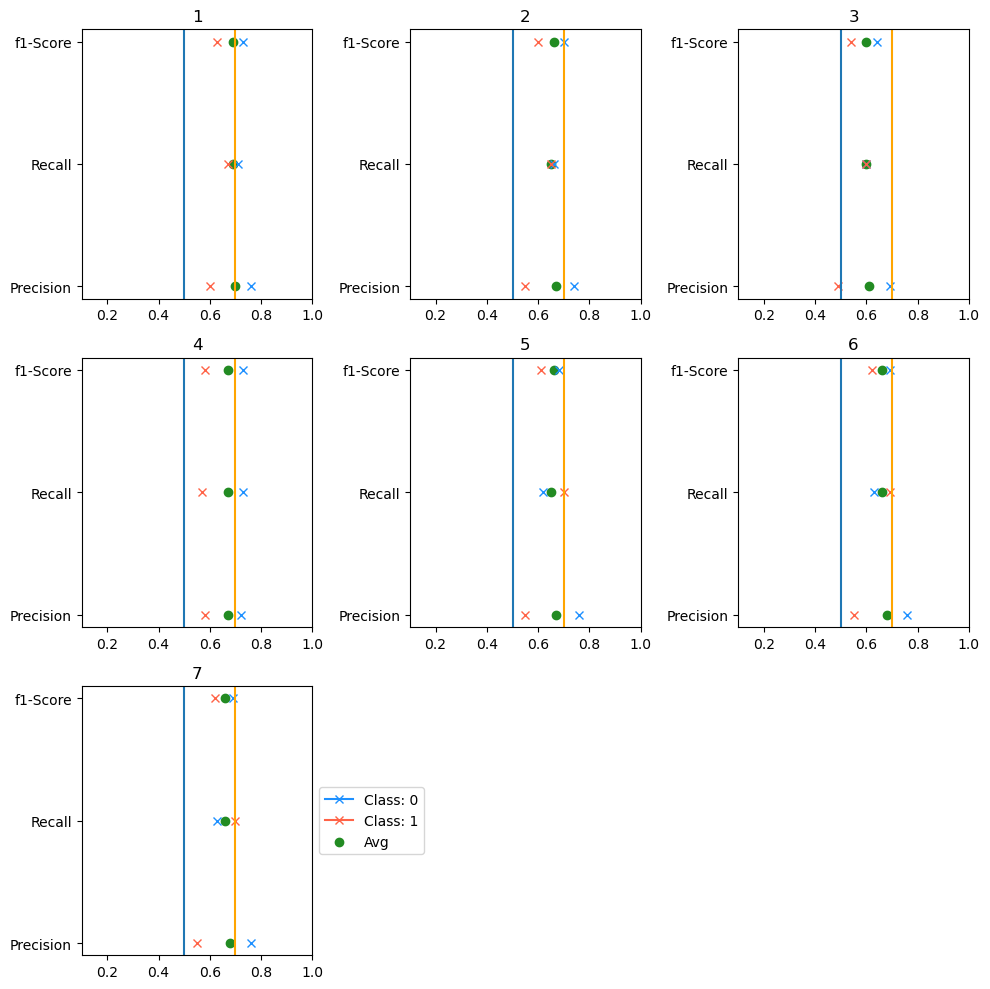

In [18]:
pred = [y1, y2, y3, y4, y5, y6, y7]

plt.figure(figsize=(10,10))
for i, pred in enumerate(pred):
    plt.subplot(3, 3, i+1)
    plot_classification_report(y_test, pred)
    plt.axvline(.5)
    plt.axvline(.7, color='orange')
    plt.xlim((0.1, 1))
    plt.title(i+1)
    plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

* El modelo con mejor desempeño es el de Naive Bayes, con un accuracy del 69%, pero presenta algunas dificultades para identificar de buena manera los valores 1 (polaridad negativa) con un valor f1 del 63% 

* El segundo mejor modelo corresponde al de LigthGBM, con un accuracy del 66%, aún así, tiene problemas para lograr identificar la clase 1 (porlaridad negativa)